<style type="text/css">

.reveal p {
    font-family: 'Raleway', sans-serif;
}

div.warn {    
    background-color: #fcf2f2;
    border-color: #dFb5b4;
    border-left: 5px solid #dfb5b4;
    padding: 0.5em;
}

body > div.reveal.slide.center.focused.has-vertical-slides.has-horizontal-slides.ready > div.slides > section.stack.present > section {
    top: 0px !important
}

.slides {
  width: 95% !important;
  height: 95% !important;
}

.centert {
  display: block;
  margin-left: auto !important;
  margin-right: auto !important;
  width: 50%;
}

table td{
border:none;
vertical-align: top;
}

.h3 {
  background: #FCD900
}

#test {
  position: fixed;
  left: 50%;
  bottom: -20px;
  transform: translate(-50%, -50%);
  margin: 0 auto;
}

</style>

<!--h1><center><br><br><span style="background:black; color:white">&nbsp;Grape-Powered Industries Inc.&nbsp;</span></center></h1-->
<!--img src="Logo.png" class="centert"/--> 
<h1><center>Superstore Dataset</center></h1>
<h4><center>ML Clustering with K-means</center></h4>
<br />
<h6><center>Stefan Dingler | 01.06.2023</center><h6>

jupyter-nbconvert.exe .\K-Means_Clustering.ipynb --to slides --post serve

## INIT

In [2]:
import sqlite3
import pandas as pd

import seaborn as sns  #for data visualization operations
import matplotlib.pyplot as plt  #for data visualization operation

import plotly
import plotly.express as px
plotly.offline.init_notebook_mode()

In [3]:
def dict_factory(cursor, row):
    fields = [column[0] for column in cursor.description]
    return {key: value for key, value in zip(fields, row)}

In [4]:
# to show all rows and columns 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
def run(sql):
    r = cur.execute(sql)
    return(r.fetchall())

## DB Connect

In [6]:
# set plt parameters
plt.style.use('seaborn')

con = sqlite3.connect("../M1P5S1-SQL/superstore.db")
con.row_factory = dict_factory
cur = con.cursor()

## DB Query - Data

In [7]:
data = (pd.DataFrame(run("""
    SELECT
        Customer_ID,
        Customer_Name,
        Segment,
        sum(Sales) As Amount,
        count(distinct(Row_ID)) AS Orders,
        count(distinct(Cart_ID)) AS Purchases
    FROM Purchase P
    LEFT JOIN Customer CU ON P.Customer_ID = CU.ID
    LEFT JOIN Cart C ON P.Cart_ID = C.ID
    GROUP BY Customer_ID
    ORDER BY Orders DESC
""")))
display(data.head())

Customer_ID    Customer_Name      Segment       Amount  Orders  Purchases
0          553  Muhammed Yedwab    Corporate  29642.66118     108         39
1          717      Steven Ward    Corporate  25668.48600     106         38
2          590  Patrick O'Brill     Consumer  26707.45620     102         45
3          295       Gary Hwang     Consumer  24625.59300     102         41
4           89      Bill Eplett  Home Office  28479.16740     102         42

## DB Query - average_distance

In [8]:
average_distance = (pd.DataFrame(run("""
SELECT 
    Customer_ID, 
    AVG(days_between_orders) AS Frequency,
    julianday('2014-12-31') - julianday(MAX(order_date)) AS Recency
FROM (
    SELECT 
        Customer_ID, 
        order_date,
        julianday(order_date) - julianday(LAG(order_date) OVER (PARTITION BY customer_id ORDER BY order_date)) AS days_between_orders
    FROM Purchase
) AS subquery
GROUP BY Customer_ID
ORDER BY Frequency ASC
""")))


In [9]:
data = pd.merge(data, average_distance, on="Customer_ID", how="outer").drop_duplicates()

## DB Disconnect

In [10]:
cur.close()
con.close()

# Clustering
When working with sales data, a common thing to do is to understand the customers' buying patterns using 3 parameters: 
* Monetary (amount of money spent)
* Frequency (how frequently the customer bought something) 
* Recency (how many days has passed from today to their last purchase).

These parameters are not given to us; we will have to calculate them.

First, we will create a new DataFrame by grouping the customers based on their ID and summing the Sales column:

```
data_monetary = data.groupby('Customer ID')['Sales'].sum()
data_monetary = data_monetary.reset_index()
data_monetary.head()
```

Do the same with Frequency (How many unique Order IDs are there per customer?) and the Recency (Calculate it from the last order date in the dataset) and then merge all the 3 DataFrames.

You will end up with a DataFrame similar to the one below:</br>
<img src="mon-freq-rec.jpg"> 

In [11]:
data["_filter"] = 0

In [12]:
data.head()

Customer_ID    Customer_Name      Segment       Amount  Orders  Purchases  \
0          553  Muhammed Yedwab    Corporate  29642.66118     108         39   
1          717      Steven Ward    Corporate  25668.48600     106         38   
2          590  Patrick O'Brill     Consumer  26707.45620     102         45   
3          295       Gary Hwang     Consumer  24625.59300     102         41   
4           89      Bill Eplett  Home Office  28479.16740     102         42   

   Frequency  Recency  _filter  
0  38.078947      0.0        0  
1  34.945946     15.0        0  
2  32.522727      4.0        0  
3  35.450000     18.0        0  
4  32.268293     35.0        0

### Show Distribution of data

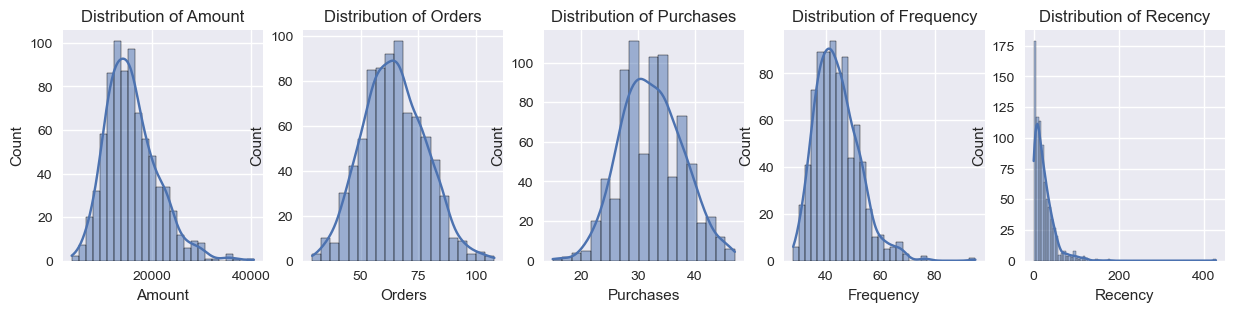

In [13]:
plt.figure(figsize=(15,3))
i = 0
for col in data:
    if (col != "Customer_ID") & (not col.startswith("_")) & ( data[col].dtype in ['int64', 'float64']):
        plt.subplot(1,5,i+1)

#        plt.tight_layout(pad=2,h_pad=2)
        plt.title(f"Distribution of {col}")
        sns.histplot(data[col],  kde=True)
        i += 1

## Pairplot

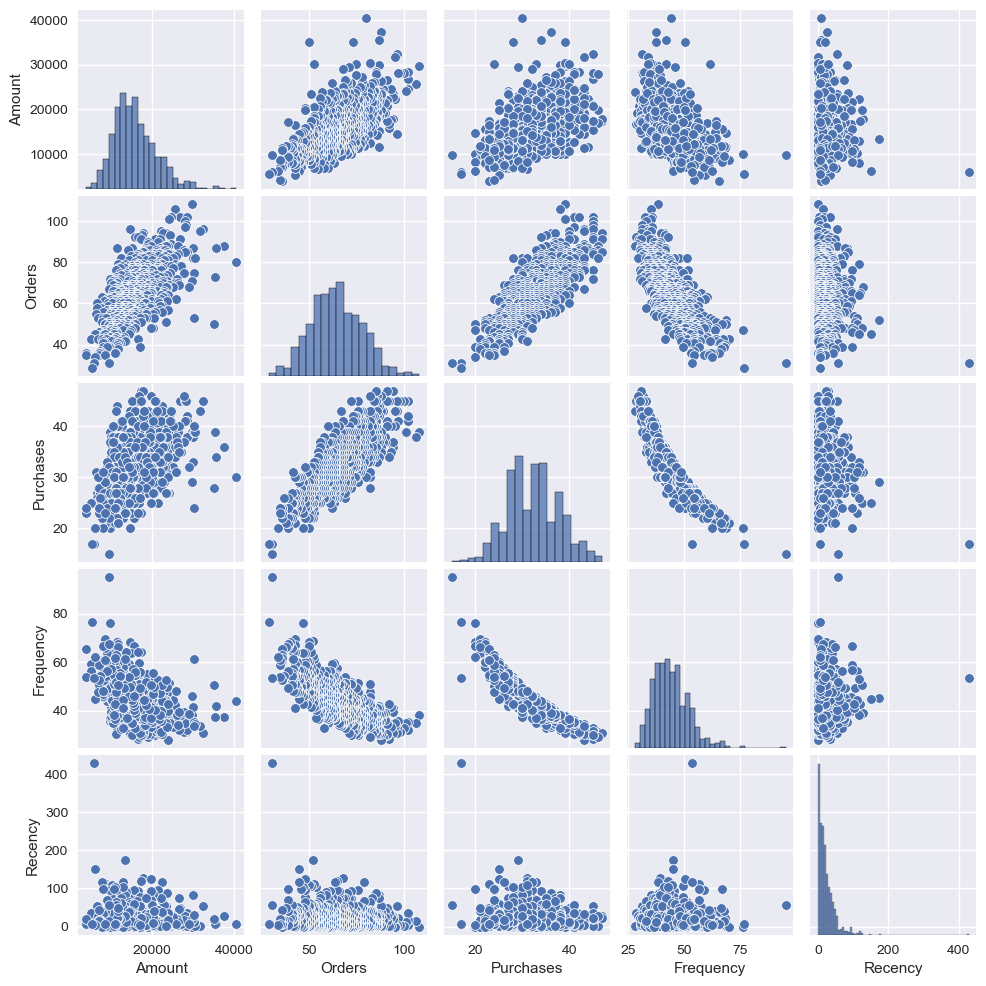

In [14]:
sns.pairplot(data[["Amount", "Orders", "Purchases", "Frequency", "Recency"]], height=2)
plt.show()

## Dealing with outliers
Try to visualize with a boxplot these 3 parameters: are there outliers? Because of its nature, the K-Means algorithm is susceptible to outliers. To check the consequences of having outliers when using a K-Means algorithm, read this article: Effect of outliers on K-Means algorithm using Python

Remove each feature's (statistical) outliers using the Interquartile Range (IQR is the difference between the upper quartile and the lower quartile).

### Removing outliers

In [27]:
total = 0
for col in data:
    if (col != "Customer_ID") & (not col.startswith("_")) & ( data[col].dtype in ['int64', 'float64']):
        Q1 = data[[col]].quantile(0.25)
        Q3 = data[[col]].quantile(0.75)
        IQR = Q3 - Q1
        outliers = data[((data[[col]] < (Q1 - 1.5 * IQR)) | ( data[[col]] > (Q3 + 1.5 * IQR))).any(axis=1)]
        data.loc[((data[[col]] < (Q1 - 1.5 * IQR)) |(data[[col]] > (Q3 + 1.5 * IQR))).any(axis=1), '_filter'] = 1
        if ( len(outliers) ):
            total += len(outliers)
            print(f"Removed {len(outliers)} entries due to {col} (Mean: {round(data[col].mean(), 2)}/Q1: {round(float(Q1), 2)}/Q3: {round(float(Q3), 2)}/IQR: {round(float(IQR), 2)})")
            display(outliers.head(2))
print(f"A total of {data[data._filter == 1].shape[0]} datasets out of {data.shape[0]} were removed")

Removed 16 entries due to Amount (Mean: 15902.52/Q1: 12242.61/Q3: 18770.8/IQR: 6528.19)


Customer_ID    Customer_Name    Segment       Amount  Orders  Purchases  \
0           553  Muhammed Yedwab  Corporate  29642.66118     108         39   
10           74     Bart Watters  Corporate  32310.44650      96         45   

    Frequency  Recency  _filter  
0   38.078947      0.0        1  
10  30.909091     54.0        1

Removed 2 entries due to Orders (Mean: 64.52/Q1: 55.0/Q3: 74.0/IQR: 19.0)


Customer_ID    Customer_Name    Segment       Amount  Orders  Purchases  \
0          553  Muhammed Yedwab  Corporate  29642.66118     108         39   
1          717      Steven Ward  Corporate  25668.48600     106         38   

   Frequency  Recency  _filter  
0  38.078947      0.0        1  
1  34.945946     15.0        1

Removed 1 entries due to Purchases (Mean: 32.39/Q1: 28.0/Q3: 36.0/IQR: 8.0)


Customer_ID Customer_Name    Segment     Amount  Orders  Purchases  \
793          198   Darren Budd  Corporate  9679.2392      31         15   

     Frequency  Recency  _filter  
793  95.071429     57.0        1

Removed 15 entries due to Frequency (Mean: 44.12/Q1: 38.21/Q3: 48.81/IQR: 10.61)


Customer_ID   Customer_Name   Segment      Amount  Orders  Purchases  \
655          209  David Flashing  Consumer  11542.0359      52         22   
673          678      Sarah Bern  Consumer  14598.1740      50         20   

     Frequency  Recency  _filter  
655  68.619048      9.0        1  
673  68.526316      2.0        1

Removed 40 entries due to Recency (Mean: 23.37/Q1: 6.0/Q3: 33.0/IQR: 27.0)


Customer_ID   Customer_Name   Segment       Amount  Orders  Purchases  \
34          608    Peter Fuller  Consumer  29875.99966      87         38   
39           61  Arthur Prichep  Consumer  18545.94030      87         37   

    Frequency  Recency  _filter  
34  35.216216     83.0        1  
39  38.361111     76.0        1

A total of 70 datasets out of 795 were removed


### Boxplots

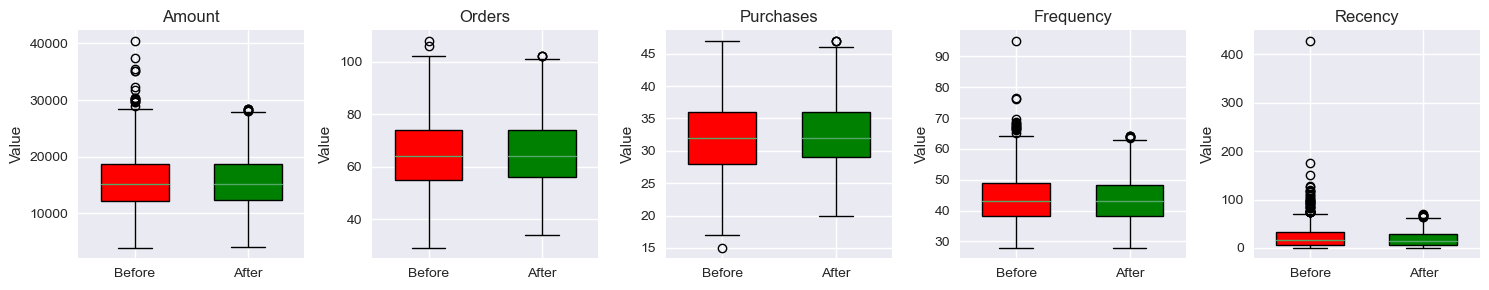

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=len(data.columns.drop(["_filter", "Customer_ID", 'Customer_Name', 'Segment'])), figsize=(15, 3))

i = 0
for col in data:
    if (col != "Customer_ID") & (not col.startswith("_")) & ( data[col].dtype in ['int64', 'float64']):
        axs[i].boxplot(data[col], positions=[0], widths=0.6, patch_artist=True, boxprops=dict(facecolor='red'))
        axs[i].boxplot(data[data["_filter"] == 0][col], positions=[1], widths=0.6, patch_artist=True, boxprops=dict(facecolor='green'))
        axs[i].set_title(col)
        axs[i].set_xticks([0, 1])
        axs[i].set_xticklabels(['Before', 'After'])
        axs[i].set_ylabel("Value")
        i += 1
plt.tight_layout()
plt.show()

### Outliers 3D

In [29]:
fig = px.scatter_3d(data, x="Amount", y="Frequency", z="Recency", color='_filter', hover_data=['Customer_Name', 'Customer_ID', 'Segment'])
fig.update_layout(autosize = True, width = 1000, height = 500)
plotly.offline.iplot(fig, filename='simple-3d-scatter')

## Feature scaling
Because of the nature of the algorithm, it is crucial to rescale the variables so that they have a comparable scale. There are two common ways of rescaling: Min-Max scaling Standardisation (mean-0, sigma-1)

Here, we will use Standardisation Scaling.
```
# Rescaling the attributes
rfm_data = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_data_scaled = scaler.fit_transform(rfm_data)
rfm_data_scaled.shape

rfm_data_scaled = pd.DataFrame(rfm_data_scaled)
rfm_data_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_data_scaled.head()
```

## Feature Scaling

In [33]:
from sklearn.preprocessing import StandardScaler

rfm_data = data[data['_filter'] == 0][['Amount', 'Orders', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_data_scaled = scaler.fit_transform(rfm_data)
rfm_data_scaled.shape

rfm_data_scaled = pd.DataFrame(rfm_data_scaled)
rfm_data_scaled.columns = ['Amount', 'Orders', 'Recency']
rfm_data_scaled.head()

Amount    Orders   Recency
0  2.393696  2.901045 -0.954918
1  1.940954  2.901045 -0.070735
2  2.778989  2.901045  1.002917
3  1.851978  2.823098 -0.449670
4  2.693140  2.745150 -1.081230

## Building the model
K-means clustering is one of the simplest and most popular unsupervised machine learning algorithms. The algorithm works as follows:

* First, we randomly initialize k points, called means. In this case, we will use 4 as a value.
* We categorize each item to its closest mean and update the mean's coordinates, which are the averages of the items categorized in that mean so far.
* We repeat the process for a given number of iterations, and, in the end, we have our clusters.
```
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_data_scaled)
```
```
# Assign the labels to each data point, and execute the following script.
kmeans.labels_
label_list=kmeans.labels_
sorted(Counter(label_list).items())
```

## Building the Model

In [34]:
from collections import Counter
from sklearn.cluster import KMeans

# k-means with some arbitrary k
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_data_scaled)

# Assign the labels to each data point, and execute the following script.
kmeans.labels_
label_list=kmeans.labels_
sorted(Counter(label_list).items())

[(0, 250), (1, 290), (2, 185)]

## Finding the optimal number of clusters
As said before, we randomly decided that the number of clusters is 4. However, is it the optimal number?

There are two methods to determine the best k: the Elbow method and the Silhouette analysis.

### The Elbow Method

According to the article Elbow Method for optimal value of k in KMeans, " a fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k."

Although our first thought might be that increasing the number of parameters (k) will improve the fit of our model, we risk overfitting it. The Elbow Curve will help us identify when, if we were to add more clusters, it would only add so much more information to our model. The optimal k value will be where the average distance falls off suddenly. Which is when the curve starts to become parallel to the x-axis.
```
# Elbow-curve /SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_data_scaled)

    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
plt.plot(ssd)
```
</br>
<img src="elbow_curve.png"> 

In this case, we can assume that the optimal number of clusters is 3, but it needs to be clarified as the Elbow is not very prominent.

Silhouette Analysis

Another way to determine the number of clusters is by using Silhouette Analysis. According to the scikit-learn documentation, " can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually." Some people argue that the Silhouette Analysis is better than the Elbow Method.
</br>
<img src="sil-score.png"> 


* p is the mean distance to the points in the nearest cluster that the data point is not a part of.
* q is the mean intra-cluster distance to all the points in its own cluster.
* The value of the silhouette score range lies between -1 to 1.
* A score closer to 1 indicates that the data point is very similar to other data points in the cluster.
* A score of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters.
* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.
```
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_data_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_data_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
```
Based on the information given here and some research online, determine whether k=3 is the right choice.

## Finding the optimal number of clusters

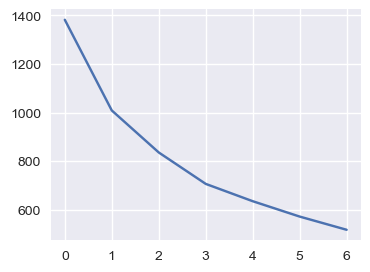

In [35]:
# Elbow-curve /SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_data_scaled)
    ssd.append(kmeans.inertia_)

plt.figure(figsize=(4, 3))
plt.plot(ssd)
plt.show()

## Finding the optimal number of clusters

In [36]:
from sklearn.metrics import silhouette_score

# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_data_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_data_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.3167830365749075
For n_clusters=3, the silhouette score is 0.3181204143217301
For n_clusters=4, the silhouette score is 0.2749789299363218
For n_clusters=5, the silhouette score is 0.28210114352202315
For n_clusters=6, the silhouette score is 0.27037284226879804
For n_clusters=7, the silhouette score is 0.26207652334402803
For n_clusters=8, the silhouette score is 0.27083007192891345



## Train your model
Now train your final model with the appropriate value of k.

Then, assign the resulting labels to the Monetary, Frequency, and Recency DataFrame (before scaling).
```
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()
And then try to visualize the results:

# Box plot to visualize Cluster Id vs Amount
sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

# Box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)
```
Now that you've gone through these basic steps, you can draw conclusions about the behavior of the three groups.

## Train the model

In [37]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_data_scaled)

# Assign the labels to each data point, and execute the following script.
kmeans.labels_
label_list=kmeans.labels_
sorted(Counter(label_list).items())

[(0, 290), (1, 250), (2, 185)]

In [38]:
df = data[data['_filter']==0]
df['Cluster_Id'] = kmeans.labels_ # assign the label

C:\Users\Coding\AppData\Local\Temp\ipykernel_15120\926219961.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



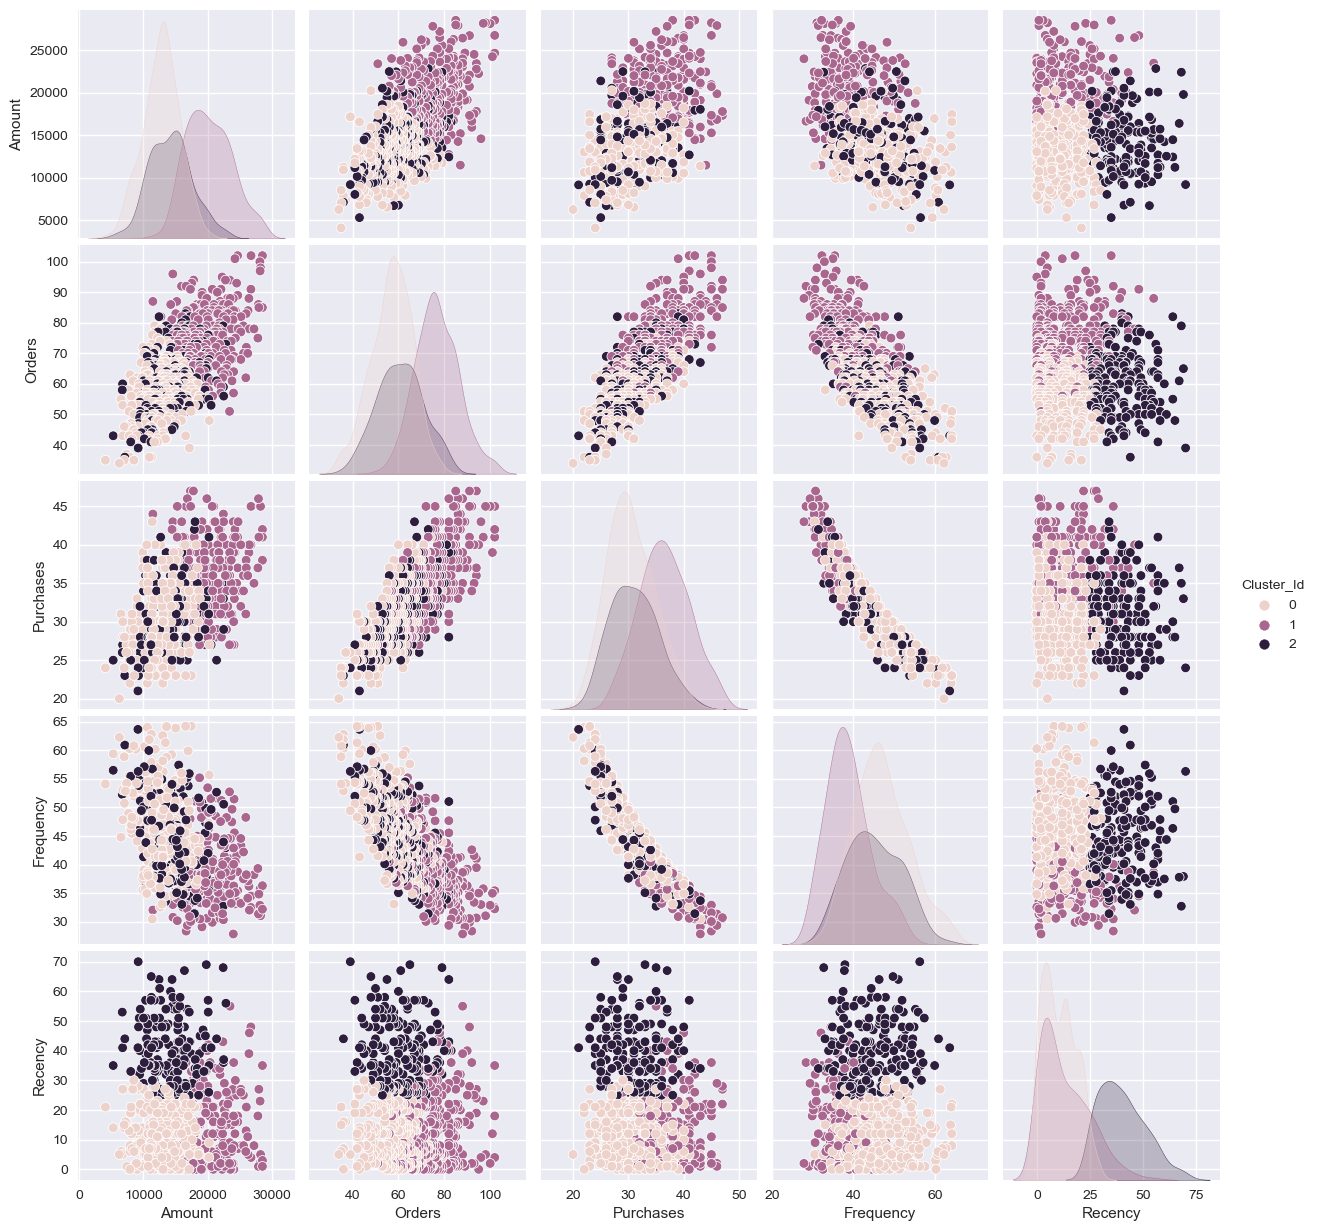

In [39]:
sns.pairplot(df[["Amount", "Orders", "Purchases", "Frequency", "Recency", "Cluster_Id"]],hue="Cluster_Id")

## Boxplot

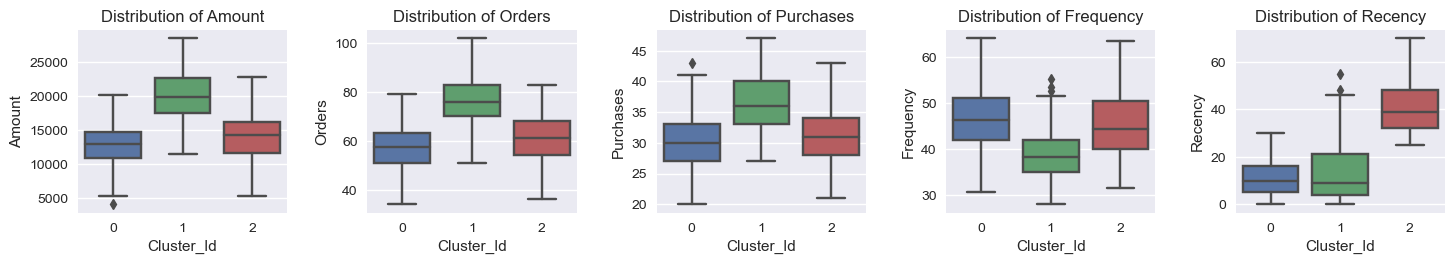

In [40]:
plt.figure(figsize=(15,3))
for index,i in enumerate(df[["Amount", "Orders", "Purchases", "Frequency", "Recency"]]):
    plt.subplot(1,5,index+1)
    plt.tight_layout(pad=2,h_pad=2)
    plt.title(f"Distribution of {i}")
    sns.boxplot(y=df[i],x=df.Cluster_Id)

## Describe the Clusters

In [41]:
for i in df.Cluster_Id.drop_duplicates():
    display(df[df.Cluster_Id==i].describe().loc[['count','mean','std','min','max']])
    #print(df[df.Cluster_Id==i]["Segment"].value_counts())

Customer_ID        Amount      Orders   Purchases   Frequency  \
count   250.000000    250.000000  250.000000  250.000000  250.000000   
mean    398.832000  20215.345404   76.756000   36.520000   38.842505   
std     229.999537   3484.319610    9.342677    4.511654    5.504961   
min       1.000000  11482.914800   51.000000   27.000000   27.880952   
max     794.000000  28479.992260  102.000000   47.000000   55.192308   

          Recency  _filter  Cluster_Id  
count  250.000000    250.0       250.0  
mean    13.292000      0.0         1.0  
std     11.312942      0.0         0.0  
min      0.000000      0.0         1.0  
max     55.000000      0.0         1.0

Customer_ID        Amount      Orders   Purchases   Frequency  \
count   185.000000    185.000000  185.000000  185.000000  185.000000   
mean    363.172973  14221.230657   60.783784   31.037838   45.130681   
std     225.809082   3291.464674    9.993300    4.316762    6.597778   
min       4.000000   5324.973180   36.000000   21.000000   31.439024   
max     791.000000  22816.192300   83.000000   43.000000   63.650000   

          Recency  _filter  Cluster_Id  
count  185.000000    185.0       185.0  
mean    40.221622      0.0         2.0  
std     10.780899      0.0         0.0  
min     25.000000      0.0         2.0  
max     70.000000      0.0         2.0

Customer_ID        Amount      Orders   Purchases   Frequency  \
count   290.000000    290.000000  290.000000  290.000000  290.000000   
mean    398.637931  12751.844045   57.010345   30.420690   46.946079   
std     228.705148   2815.788509    8.901415    4.252691    6.779737   
min       3.000000   4115.208000   34.000000   20.000000   30.500000   
max     795.000000  20225.357840   79.000000   43.000000   64.181818   

          Recency  _filter  Cluster_Id  
count  290.000000    290.0       290.0  
mean    10.682759      0.0         0.0  
std      7.669382      0.0         0.0  
min      0.000000      0.0         0.0  
max     30.000000      0.0         0.0

## Consider more parameters (optional)
The above analysis is elementary: it only considers 3 elements of a dataset that contains a lot of information.

Try to think about other parameters that you could consider in the analysis that makes sense. For example: Are there any perceivable differences in behavior between Corporate and Consumer Segments? Could you deduce patterns between the product categories? Are there any noteworthy differences between the states?

## 3D visualisation

In [42]:
fig = px.scatter_3d(df, x="Amount", y="Orders", z="Recency", color='Cluster_Id', hover_data=['Customer_Name', 'Customer_ID', 'Segment'])
fig.update_layout(autosize = True, width = 1000, height = 500)
plotly.offline.iplot(fig, filename='simple-3d-scatter')